# Topics
* [Trasnformations](#1)
    * translation
    * Rotation
    * Affine
    * Projective

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
FLOWER_IMAGE = 'flower.jpeg'

IMAGE_SHAPE = (350, 350)

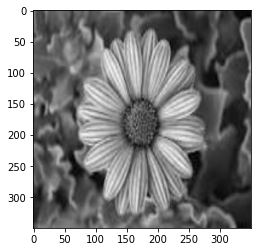

In [3]:
flower_im = cv2.imread(FLOWER_IMAGE, 0)
flower_im = cv2.resize(flower_im, IMAGE_SHAPE)
plt.imshow(flower_im, cmap='gray')

<a id=1></a>
# Transformations

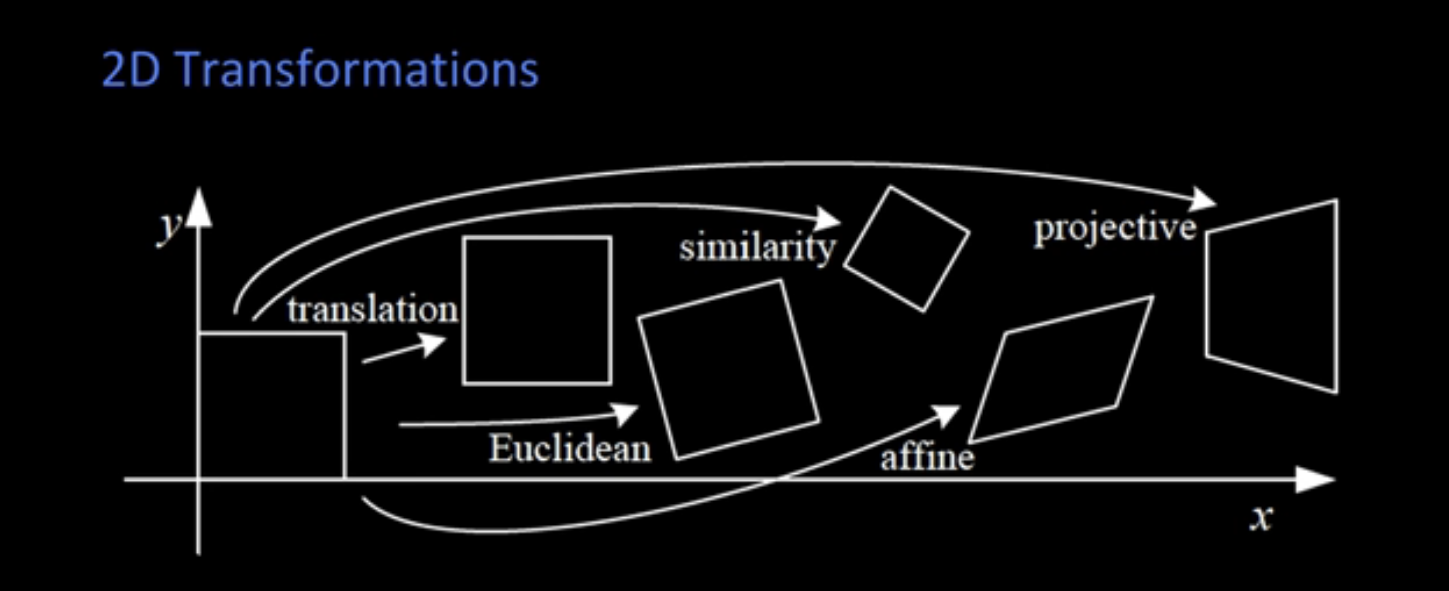

There are various types of transformations can be applied to 2D images:
* Translation
* Euclidean
* Similarity
* Affine
* Projective

### First Translation:
`1`. when you move image to another place (move each point with the same x and y magnitude).<br>
`2`. you need only one pair points (point ant its analogue in the translated image) to evaluate the translation magnitude.<br>
`3`. there are two variables used in this process the dx and dy.<br>

$$M = \begin{bmatrix} 1 &  0 & dx \\ 0 & 1 & dy \\ 0 & 0 & 1 \end{bmatrix}$$ 

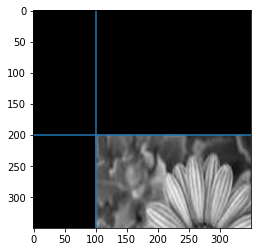

In [4]:
# translation
dx, dy = 100, 200
temp_shape = flower_im.shape[0] + dy, flower_im.shape[1] + dx
temp_im = np.zeros(temp_shape)
for x in range(len(flower_im)):
    for y in range(len(flower_im)):
        try:
            temp_im[x + dy, y + dx] = flower_im[x, y]
        except IndexError:
            break
            
plt.imshow(temp_im[:350, :350], cmap='gray')
plt.axvline(dx)
plt.axhline(dy)

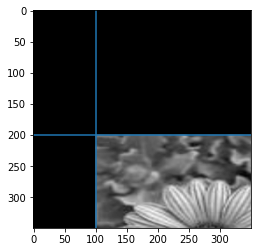

In [5]:
# using matrix multiplication
M = np.array([[1, 0, dx], [0, 1, dy], [0, 0, 1]], dtype='float32')

X, Y = np.arange(flower_im.shape[0]), np.arange(flower_im.shape[1])
XY = np.array([X, Y, np.ones(len(X))])

XY_ = np.dot(M, XY)
X_ = XY_[0] // XY_[-1]
Y_ = XY_[1] // XY_[-1]
X_, Y_ = X_.astype('int'), Y_.astype('int')
translated_im = np.zeros(flower_im.shape)

for i in range(len(flower_im)):
    for j in range(len(flower_im)):
        
        try:
            Color = cv2.cvtColor(np.array(flower_im[X[i], Y[j]]), cv2.COLOR_GRAY2RGB)
            Color = tuple(Color[0, 0].tolist())
            cv2.circle(translated_im, (X_[i], Y_[j]), radius=0, color=Color)
        except IndexError:
            break

plt.imshow(translated_im, cmap='gray');
plt.axvline(100)
plt.axhline(200)

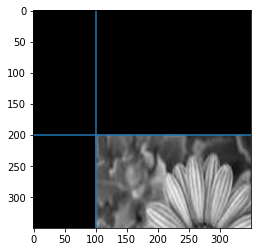

In [6]:
# Using opencv
M = np.array([[1, 0, dx], [0, 1, dy]], dtype='float32')
translated_im = cv2.warpAffine(flower_im, M, flower_im.shape)
plt.imshow(translated_im, cmap='gray')
plt.axvline(dx)
plt.axhline(dy)

### Second Euclidean (Rotation):
`1`. Rotate image with angle  $ = \theta$<br>
`2`. you need only two pairs of points to evaluate the rotation and translation magnitude.<br>
`3`.  there are four variables used in this process the dx, dy, $\theta$ and $\sigma$.<br>

$$ M = \begin{bmatrix}\sigma * cos(\theta) & - \sigma * sin(\theta) & dx 
                   \\ \sigma * sin(\theta) & \sigma * cos(\theta) & dy 
                   \\ 0 & 0 & 1 \end{bmatrix}$$
                   
                   
#### Transform Equation:
$$ \begin{bmatrix} X^` \\ Y^` \\ 1 \end{bmatrix} = M_{(3*3)} *   \begin{bmatrix} X \\ Y \\ 1 \end{bmatrix}$$

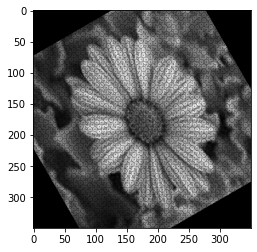

In [7]:
THETA = np.pi / 3
SIGMA = 1

M_rotation = np.array([[SIGMA*np.cos(THETA), -SIGMA*np.sin(THETA), 0],
              [SIGMA*np.sin(THETA), SIGMA*np.cos(THETA), 0],
              [0, 0, 1]], dtype='float32')

new_center = (M_rotation @ [350//2, 350//2, 1]).astype('int')[:-1]
dx = 350//2 - new_center[0]
dy = 350//2 - new_center[1]

M_rotation[:-1, -1] = [dx, dy]

rotated_im = np.zeros(IMAGE_SHAPE)
 
for i in range(350):
    for j in range(350):
        x_, y_, _ = M_rotation @ [X[i], Y[j], 1]
        x_, y_ = int(x_), int(y_)
        try :
            
            Color = cv2.cvtColor(np.array(flower_im[X[i], Y[j]]), cv2.COLOR_GRAY2RGB)
            Color = tuple(Color[0, 0].tolist())
            
            cv2.circle(rotated_im, (x_, y_), radius=0, color=Color)
        except:
            continue

plt.imshow(rotated_im, cmap='gray');

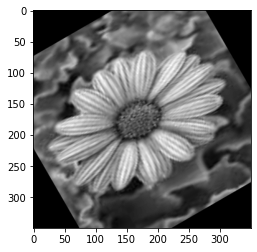

In [8]:
# Using opencv 
dst = cv2.warpAffine(flower_im, M_rotation[:-1], flower_im.shape)
plt.imshow(dst, cmap='gray');

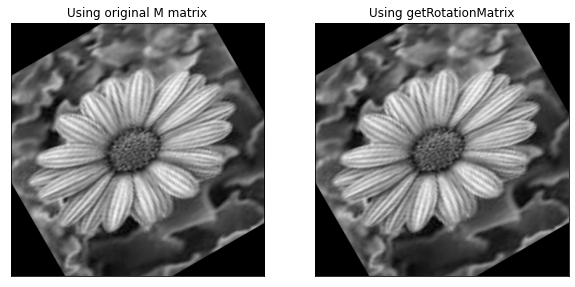

In [9]:
# Using get rotation matrix
THETA = - 180 / 3
SCALE = 1
M_ = cv2.getRotationMatrix2D((350//2, 350//2), THETA, SCALE)

dst2 = cv2.warpAffine(flower_im, M_, flower_im.shape)



plt.figure(figsize=(10, 10))
fig = plt.subplot(1, 2, 1)
fig.imshow(dst, cmap='gist_gray')
fig.set_title('Using original M matrix')
fig.axes.xaxis.set_visible(False)
fig.axes.yaxis.set_visible(False)

fig = plt.subplot(1, 2, 2)
fig.imshow(dst2, cmap='gist_gray')
fig.set_title('Using getRotationMatrix')
fig.axes.xaxis.set_visible(False)
fig.axes.yaxis.set_visible(False)

### Third Affine:
`1`. warps the image with preserving:<br>
> * Parallel lines.<br>
> * Ratio of areas (ratios between shapes in image will remain constant).<br>
> * Lines (Lines are mapped to lines in affined image).<br>

`2`. you need three pairs of points to get the original image back.<br>
`3`. there are six variables (degrees of freedom) used in this process the a, b, c, d, e, f.</br>

$$ M = \begin{bmatrix} a & b & c 
                    \\ d & e & f 
                   \\ 0 & 0 & 1 \end{bmatrix}$$
                   
                   
#### Transform Equation:
$$ \begin{bmatrix} X^` \\ Y^` \\ 1 \end{bmatrix} = M_{(3*3)} *   \begin{bmatrix} X \\ Y \\ 1 \end{bmatrix}$$

$$ X^` = aX + bY + c$$</br>
$$Y^` = dX + eY + f $$

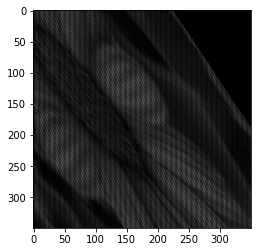

In [10]:
a, b, c, d, e, f = 2, 2, 100, 3, 1, 50

M = np.array([[a, b, c], [d, e, f], [0, 0, 1]], dtype='float32')

new_center = (M @ [350//2, 350//2, 1]).astype('int')[:-1]
dx = 350//2 - new_center[0]
dy = 350//2 - new_center[1]

M[:-1, -1] = [dx, dy]

affined_im = np.zeros(IMAGE_SHAPE)
 
for i in range(350):
    for j in range(350):
        x_, y_, _ = M @ [X[i], Y[j], 1]
        x_, y_ = int(x_), int(y_)
        try :
            
            Color = cv2.cvtColor(np.array(flower_im[X[i], Y[j]]), cv2.COLOR_GRAY2RGB)
            Color = tuple(Color[0, 0].tolist())
            
            cv2.circle(affined_im, (x_, y_), radius=0, color=Color)
        except:
            continue

plt.imshow(affined_im, cmap='gray');

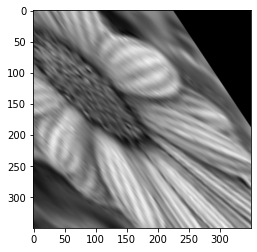

In [11]:
# Using opencv
dst = cv2.warpAffine(flower_im, M[:-1], flower_im.shape)
plt.imshow(dst, cmap='gray');

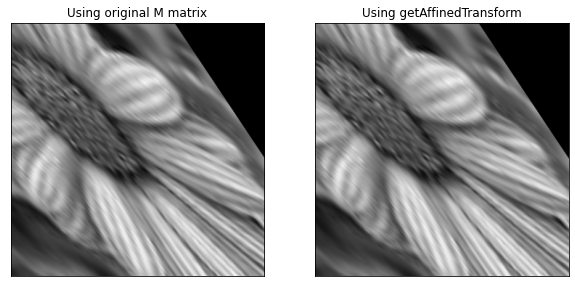

In [12]:
# Using getAffineTransform() function :
# we need three points in the original image ant their corresponding in affined image

pts1 = np.float32([[50,50],[200,50],[50,200]])
pts2 = np.float32([*map(lambda x : (M @ [x[0], x[1], 1])[:-1], pts1)])

M = cv2.getAffineTransform(pts1,pts2)

dst2 = cv2.warpAffine(flower_im, M, flower_im.shape)



plt.figure(figsize=(10, 10))
fig = plt.subplot(1, 2, 1)
fig.imshow(dst, cmap='gist_gray')
fig.set_title('Using original M matrix')
fig.axes.xaxis.set_visible(False)
fig.axes.yaxis.set_visible(False)

fig = plt.subplot(1, 2, 2)
fig.imshow(dst2, cmap='gist_gray')
fig.set_title('Using getAffinedTransform')
fig.axes.xaxis.set_visible(False)
fig.axes.yaxis.set_visible(False)

### tip
We can consider affining is <font color='red'><strong>similar to</strong></font> rotation but with two angles $ \theta , \phi$ instead of only $\theta$


$$ M = \begin{bmatrix}\sigma cos(\theta) & - \sigma sin(\theta) & dx 
                   \\ \sigma sin(\phi) & \sigma cos(\phi) & dy 
                   \\ 0 & 0 & 1 \end{bmatrix}$$

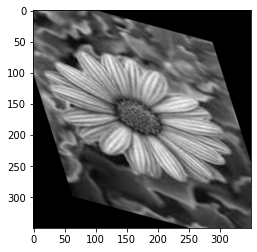

In [13]:
THETA, PHI = 2 * np.pi / 5, 7 * np.pi / 12
SCALE = 1
M = np.float32([[SCALE*np.cos(THETA), -SCALE * np.sin(THETA), 0],
                [SCALE*np.sin(PHI), SCALE * np.cos(PHI), 0],
                [0, 0, 1]])
new_center = M @ [350//2, 350//2, 1]
dx, dy = 350//2 - new_center[0], 350//2 - new_center[1]

M[:-1, -1] = dx, dy


affined_im = cv2.warpAffine(flower_im, M[:-1], IMAGE_SHAPE)
plt.imshow(affined_im, cmap='gray')

### Fourth Perspective (Projective):
#### General Projective Trasform (Homography)
`1`. preserves:<br>
> * Lines (Lines are mapped to lines in affined image).<br>

`2`. you need four pairs of points to get the original image back.<br>
`3`. there are 9 variables (degrees of freedom) used in this process the a, b, c, d, e, f, g, h, i.</br>

$$ M = \begin{bmatrix} a & b & c 
                    \\ d & e & f 
                   \\ g & h & i \end{bmatrix}$$
                   
                   
#### Transform Equation:
$$ \begin{bmatrix} wX^` \\ wY^` \\ w \end{bmatrix} = M_{(3*3)} *   \begin{bmatrix} X \\ Y \\ 1 \end{bmatrix}$$

$$ w X^` = aX + bY + c$$</br>
$$wY^` = dX + eY + f $$
    
`w` wouldn't be a problem we transforming after trasforming from homogeneous coordinates to nonhomogeneous.</br>
We can also scale `M` by a constant (e.g. `i`) with no impact after transforming to nonhomogeneous coordinates.

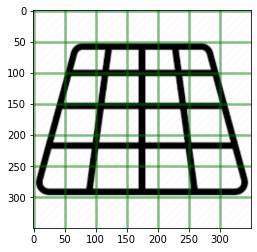

In [14]:
square_im = cv2.imread('square.png')
square_im = cv2.resize(square_im, IMAGE_SHAPE)
plt.imshow(square_im);
plt.grid(color='green', linewidth=2.5, alpha=0.5)

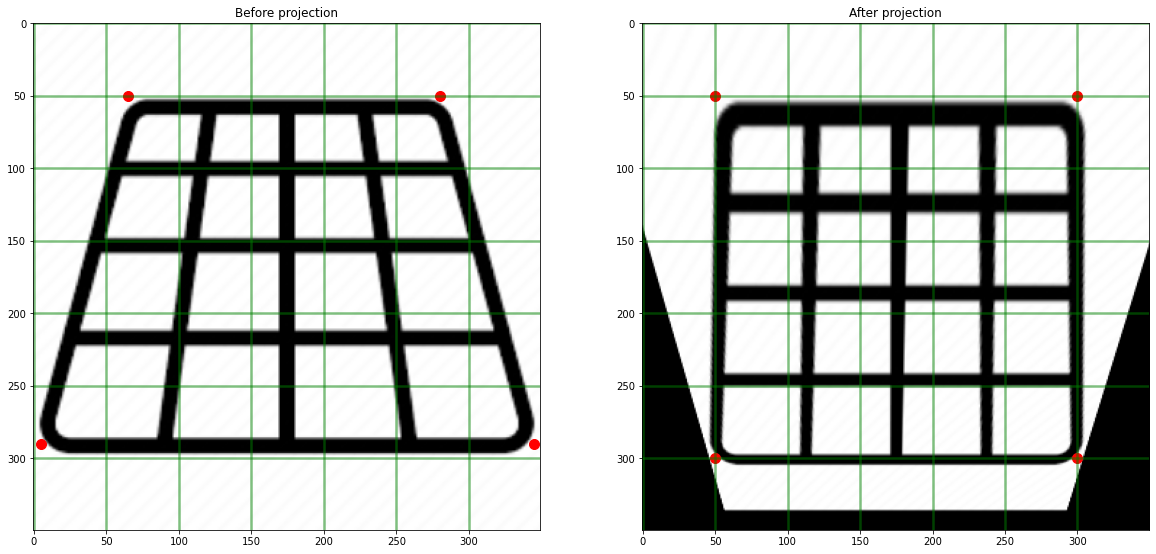

In [15]:
pts1 = [65, 50], [280, 50], [5, 290], [345, 290]
pts2 = [50, 50], [300, 50], [50, 300], [300, 300]
pts1 = np.float32(pts1)
pts2 = np.float32(pts2)
M = cv2.getPerspectiveTransform(pts1,pts2)

projected_im = cv2.warpPerspective(square_im, M, square_im.shape[:-1])


plt.figure(figsize=(20, 12))
fig = plt.subplot(1, 2, 1)
plt.imshow(square_im)
fig.set_title('Before projection')
fig.scatter(pts1[:, 0], pts1[:, 1], color='red', s=100)
fig.grid(color='green', linewidth=2.5, alpha=0.5)

fig = plt.subplot(1, 2, 2)
plt.imshow(projected_im)
fig.set_title('After projection')
fig.scatter(pts2[:, 0], pts2[:, 1], color='red', s=100)
fig.grid(color='green', linewidth=2.5, alpha=0.5)


### Determine M from four pairs of points
$$P =  \begin{bmatrix} -x_i & -y_i & -1 & 0 & 0 & 0 & x_ix_i^′ & y_ix_i^′ & x_i^′ \\ 
                0 & 0 & 0 & -x_i & -y_i & -1 & x_iy_i^′ & y_iy_i^′ & y_i^′ \end{bmatrix}
                , H = \begin{bmatrix} a \\ b \\ c \\ d \\ e \\ f \\ g \\ h \\ i \end{bmatrix}$$

$$ PH = 0 $$
#### set i = 1 to prevent trivial solution

P: matrix produced with the four pairs of points.</br>
H: array of M elements.


In [16]:
from numpy import linalg

pts = [[[-i[0], -i[1], -1, 0, 0, 0, i[0]*j[0], i[1]*j[0], j[0]],
       [0, 0, 0, -i[0], -i[1], -1, i[0]*j[1], i[1]*j[1], j[1]]] for i , j in zip(pts1, pts2)]
P = np.float32(pts)
P = np.append(P, [0, 0, 0, 0, 0, 0, 0, 0, 1])
P = P.reshape(9, 9)

H = linalg.solve(a=P, b=[0, 0, 0, 0, 0, 0, 0, 0, 1])
M_ = H.reshape(3, 3)

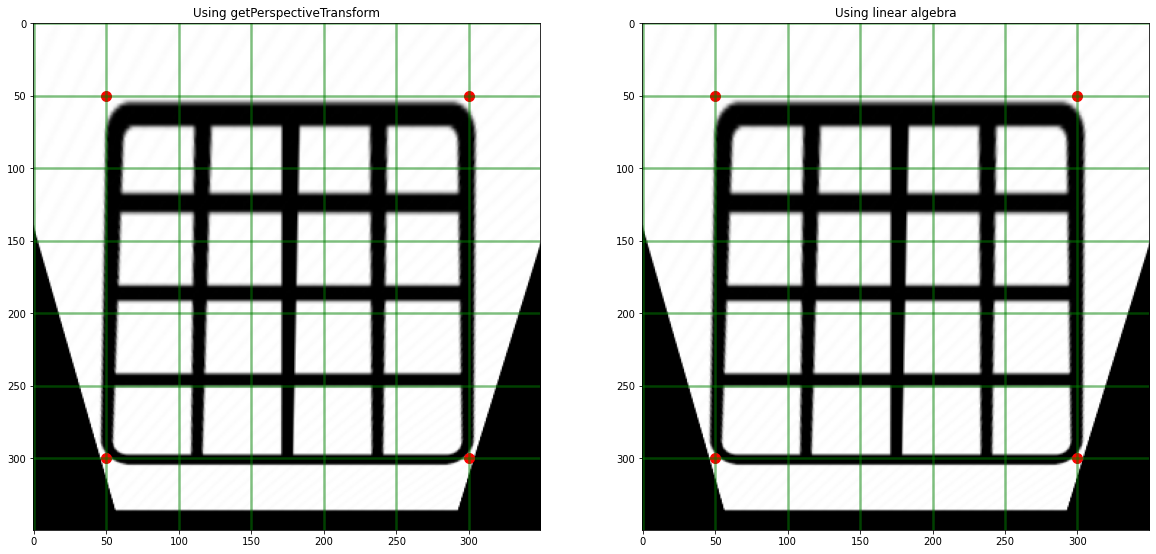

In [17]:
projected_im2 = cv2.warpPerspective(square_im, M, IMAGE_SHAPE)

plt.figure(figsize=(20, 12))
fig = plt.subplot(1, 2, 1)
plt.imshow(projected_im)
fig.set_title('Using getPerspectiveTransform')
fig.scatter(pts2[:, 0], pts2[:, 1], color='red', s=100)
fig.grid(color='green', linewidth=2.5, alpha=0.5)

fig = plt.subplot(1, 2, 2)
plt.imshow(projected_im2)
fig.set_title('Using linear algebra')
fig.scatter(pts2[:, 0], pts2[:, 1], color='red', s=100)
fig.grid(color='green', linewidth=2.5, alpha=0.5)

# For more resources:
[openCV docs](https://docs.opencv.org/3.4/da/d6e/tutorial_py_geometric_transformations.html)